### My Details

**Name** : `Rohan Ingle`    

**PRN** : `22070126047`     

**Batch** : `AIML A2 (2022-2026)`   

### GitHub Link : [https://github.com/Rohan-ingle/Natural-Language-Processing](https://github.com/Rohan-ingle/Natural-Language-Processing)

### Importing Required Libraries

In [2]:
import warnings

import re
import pandas as pd
import cudf
import cupy as cp

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

from scipy.sparse import csr_matrix
from cuml.svm import SVC as cuSVC
from cuml.ensemble import RandomForestClassifier as cuRF

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import seaborn as sns
import matplotlib.pyplot as plt



warnings.filterwarnings("ignore")

In [2]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /home/speedindeed1/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/speedindeed1/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /home/speedindeed1/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /home/speedindeed1/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /home/speedindeed1/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is a

True

---

### Loading Datasets into a `DataFrame`

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv') 

**Baisc Preprocessing**
- Lets select only necessary features

In [4]:
train["Genre"].unique()

array(['Rock', 'Metal', 'Pop', 'Indie', 'R&B', 'Folk', 'Electronic',
       'Jazz', 'Hip-Hop', 'Country'], dtype=object)

In [5]:
test["Genre"].unique()

array(['Hip-Hop', 'Indie', 'Metal', 'Pop', 'Country', 'Jazz', 'Rock',
       'R&B', 'Electronic', 'Folk'], dtype=object)

**Lets rename `Hip-Hop` to `HH` for simplicity**

In [4]:
train['Genre'] = train['Genre'].str.replace('Hip-Hop', 'HH')
test['Genre'] = test['Genre'].str.replace('Hip-Hop', 'HH')

In [7]:
train["Genre"].unique()

array(['Rock', 'Metal', 'Pop', 'Indie', 'R&B', 'Folk', 'Electronic',
       'Jazz', 'HH', 'Country'], dtype=object)

In [8]:
test["Genre"].unique()

array(['HH', 'Indie', 'Metal', 'Pop', 'Country', 'Jazz', 'Rock', 'R&B',
       'Electronic', 'Folk'], dtype=object)

**Here we will only select `English` i.e. `'en'` songs only**

In [5]:
genre = ['Rock', 'Jazz', 'HH', 'Metal', 'Country']
train = train[(train['Genre'].isin(genre)) & (train['Language'] == 'en')]

In [10]:
train.describe()

,Artist,Song,Genre,Language,Lyrics
count,143720,143719,143720,143720,143720
unique,6193,86662,5,1,127917
top,elvis presley,home,Rock,en,"My heart is sad and lonely\nFor you I sigh, fo..."
freq,1598,87,107145,143720,83


**Get insights on duplicated values**

In [6]:
duplicates = train[train['Lyrics'].duplicated(keep=False)].sort_values(by='Lyrics')

In [12]:
duplicates

,Artist,Song,Genre,Language,Lyrics
12587,cowboy junkies,take me,Rock,en,\n\nwhere the thunder meets the light\nTake me...
12469,cowboy junkies,take me,Rock,en,\n\nwhere the thunder meets the light\nTake me...
30,12 stones,back up,Rock,en,\nI hear the words you say to me\nI see the wa...
9,12 stones,back up,Rock,en,\nI hear the words you say to me\nI see the wa...
245656,george strait,lovesick blues,Rock,en,"\nI'm in love,\nI'm in love,\nI'm in love with..."
...,...,...,...,...,...
22528,george michael,you've changed,Rock,en,you've changed\nthat sparkle in your eyes has ...
9402,bush,dead meat,Rock,en,your dead meat\nyour dead meat\nyour dead meat...
9431,bush,dead meat,Rock,en,your dead meat\nyour dead meat\nyour dead meat...
11969,coheed and cambria,a favor house atlantic,Metal,en,your eyes tell the stories of a day you wish y...


In [13]:
duplicates_by_genre = train[train.duplicated(subset=['Lyrics', 'Genre'], keep=False)]

duplicate_counts_by_genre = duplicates_by_genre.groupby('Genre').size()

print(duplicate_counts_by_genre)


Genre
Jazz      6020
Metal     2495
Rock     16985
dtype: int64


In [14]:
train["Genre"].unique()

array(['Rock', 'Metal', 'Jazz', 'HH', 'Country'], dtype=object)

In [15]:
test["Genre"].unique()

array(['HH', 'Indie', 'Metal', 'Pop', 'Country', 'Jazz', 'Rock', 'R&B',
       'Electronic', 'Folk'], dtype=object)

In [16]:
test.describe()

,Song year,Track_id
count,7935.000000,7935.000000
mean,2007.943793,13262.260744
std,5.201110,7612.173049
min,1970.000000,3.000000
25%,2006.000000,6708.500000
50%,2007.000000,13169.000000
75%,2011.000000,19840.000000
max,2016.000000,26446.000000


**lets define our `stop_words` and `lemmatizer`**

In [7]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

**Here we will make a preprocessing function to clean the lyrics string and also tokenize it**

In [8]:
def text_cleaner(text):
    text = re.sub(r'\@w+|\#','', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [9]:
train['Lyrics'] = train['Lyrics'].apply(text_cleaner)

In [10]:
test = test[(test['Genre'].isin(genre))]
test['Lyrics'] = test['Lyrics'].apply(text_cleaner)

**Lets check how it affected `Lyrics` column**

In [21]:
train.head()

,Artist,Song,Genre,Language,Lyrics
0,12 stones,world so cold,Rock,en,start pain followed hate fueled endless questi...
1,12 stones,broken,Rock,en,freedom alone alone patiently waiting phone ho...
2,12 stones,3 leaf loser,Rock,en,biting hand feed lying voice inside reach beg ...
3,12 stones,anthem for the underdog,Rock,en,say know cant imagine wait across line thought...
4,12 stones,adrenaline,Rock,en,heart beating faster cant control feeling anym...


In [22]:
test.head()

,Song,Song year,Artist,Genre,Lyrics,Track_id
0,craftsmanship,2005,buck-65,HH,folk spend day daydreaming finding clue whole ...,8294
2,riot,2013,bullet-for-my-valentine,Metal,ready time war well break fucking door smash w...,3301
4,believe-in-a-dollar,2012,cassidy,HH,believe magic young girl heart music free when...,16797
5,mama-bake-a-pie-daddy-kill-a-chicken,2007,bobby-bare,Country,people starin wheel ramp toward plane war ive ...,1251
6,thinking-about-you,2007,bill-monroe,Country,sigh hour away think love yesterday know shes ...,25217


**Now we are going to encode our dataset, define vectorizers and models and transform data by vectorizing it**

- We will use `fit_transform` on training dataset and `transform` on testing

In [11]:
encode_label = LabelEncoder()
train['Genre'] = encode_label.fit_transform(train['Genre'])
test['Genre'] = encode_label.transform(test['Genre'])

In [12]:
countVec = CountVectorizer(max_features=50000)
tfidfVec = TfidfVectorizer(max_features=50000)

In [13]:
X_train_countVec = countVec.fit_transform(train['Lyrics'])
X_test_countVec = countVec.transform(test['Lyrics'])

X_train_tfidfVec = tfidfVec.fit_transform(train['Lyrics'])
X_test_tfidfVec = tfidfVec.transform(test['Lyrics'])

In [14]:
y_train = train['Genre']
y_test = test['Genre']

### Training

**We will make a function to train models**

In [15]:
def train(model, X_train, X_test, y_train, y_test, model_name, vectorizer):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"\nClassification Report for {model_name} with {vectorizer}:")
    print(classification_report(y_test, y_pred, target_names=encode_label.classes_))
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encode_label.classes_, yticklabels=encode_label.classes_)
    plt.title(f'Confusion Matrix for {model_name} with {vectorizer}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [28]:
lr = LogisticRegression(class_weight='balanced', max_iter=10000)


Classification Report for logisticRegression with Tfidf Vectorizer:
              precision    recall  f1-score   support

     Country       0.64      0.47      0.54       810
          HH       0.92      0.78      0.84       960
        Jazz       0.58      0.52      0.55       660
       Metal       0.59      0.83      0.69       810
        Rock       0.52      0.55      0.54      1410

    accuracy                           0.63      4650
   macro avg       0.65      0.63      0.63      4650
weighted avg       0.64      0.63      0.63      4650



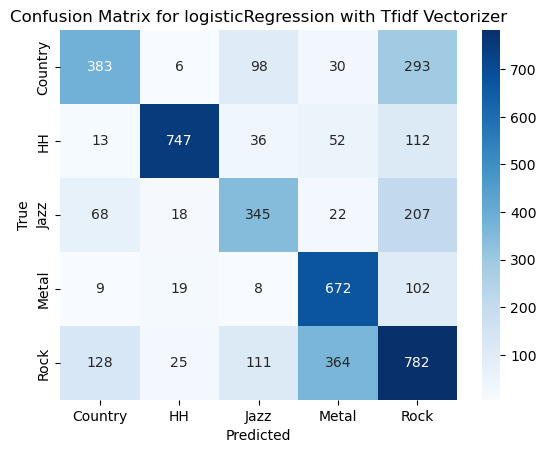

In [29]:
train(lr, X_train_tfidfVec, X_test_tfidfVec, y_train, y_test, 'logisticRegression','Tfidf Vectorizer')


Classification Report for Logistic Regression with Count Vectorizer:
              precision    recall  f1-score   support

     Country       0.66      0.28      0.39       810
          HH       0.93      0.59      0.72       960
        Jazz       0.56      0.54      0.55       660
       Metal       0.60      0.74      0.66       810
        Rock       0.46      0.67      0.54      1410

    accuracy                           0.58      4650
   macro avg       0.64      0.56      0.57      4650
weighted avg       0.63      0.58      0.57      4650



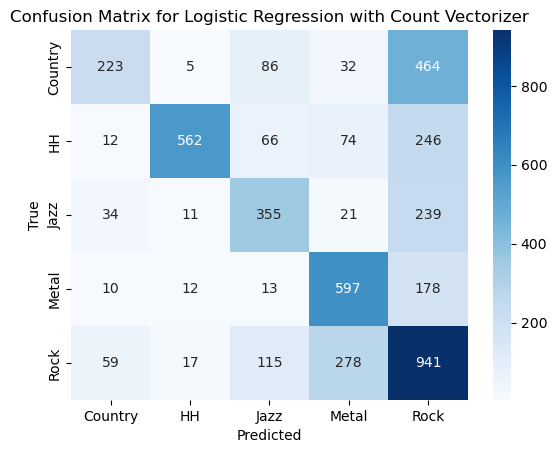

In [30]:
train(lr, X_train_countVec, X_test_countVec, y_train, y_test,"Logistic Regression", 'Count Vectorizer')

In [31]:
rf = RandomForestClassifier(class_weight='balanced')


Classification Report for Random Forest with Tfidf Vectorizer:
              precision    recall  f1-score   support

     Country       1.00      0.01      0.02       810
          HH       0.98      0.25      0.40       960
        Jazz       0.92      0.31      0.46       660
       Metal       0.86      0.29      0.43       810
        Rock       0.35      0.97      0.51      1410

    accuracy                           0.44      4650
   macro avg       0.82      0.37      0.37      4650
weighted avg       0.76      0.44      0.38      4650



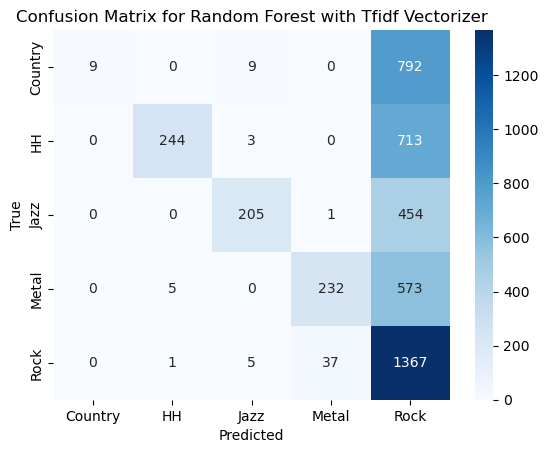

In [32]:
train(rf, X_train_tfidfVec, X_test_tfidfVec, y_train, y_test,'Random Forest','Tfidf Vectorizer')


Classification Report for Random Forest with Count Vectorizer:
              precision    recall  f1-score   support

     Country       0.88      0.02      0.03       810
          HH       0.97      0.25      0.39       960
        Jazz       0.92      0.32      0.47       660
       Metal       0.85      0.28      0.42       810
        Rock       0.35      0.97      0.52      1410

    accuracy                           0.44      4650
   macro avg       0.79      0.37      0.37      4650
weighted avg       0.74      0.44      0.38      4650



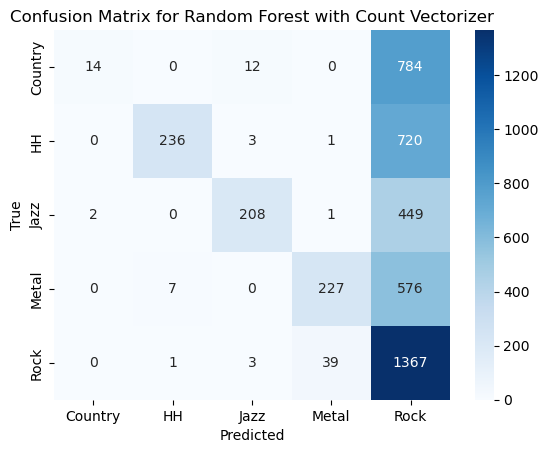

In [33]:
train(rf, X_train_countVec, X_test_countVec, y_train, y_test,'Random Forest','Count Vectorizer')

### Using cuML to train SVC on GPU to improve training time


**But first we need to convert data to support cuML library and models**

- Converting to csr_matrix ensures that sparse data, like word vectors from CountVectorizer or TF-IDF, is stored efficiently by keeping only non-zero values. This reduces memory usage and speeds up operations on large datasets.
- Switching to float32 cuts memory usage in half compared to float64. This format is more compatible with GPU-accelerated libraries like CuPy, offering a good balance between precision and performance.
- CuPy allows data to be processed on NVIDIA GPUs, speeding up computation for large datasets and complex operations. By converting to CuPy's sparse format, you take full advantage of parallel GPU processing for faster model training.

In [16]:
X_train_count_float32_csrMatrix = csr_matrix(X_train_countVec, dtype=cp.float32)
X_test_count_float32_csrMatrix = csr_matrix(X_test_countVec, dtype=cp.float32)

In [ ]:
X_train_tfidf_float32_csrMatrix = csr_matrix(X_train_tfidfVec, dtype=cp.float32)
X_test_tfidf_float32_csrMatrix = csr_matrix(X_test_tfidfVec, dtype=cp.float32)

In [ ]:
X_train_count_cupy = cp.sparse.csr_matrix(X_train_count_float32_csrMatrix)
X_test_count_cupy = cp.sparse.csr_matrix(X_test_count_float32_csrMatrix)

In [ ]:
X_train_tfidf_cupy = cp.sparse.csr_matrix(X_train_tfidf_float32_csrMatrix)
X_test_tfidf_cupy = cp.sparse.csr_matrix(X_test_tfidf_float32_csrMatrix)

In [ ]:
y_train_cupy = cp.array(y_train.to_numpy(), dtype=cp.int32)
y_test_cupy = cp.array(y_test.to_numpy(), dtype=cp.int32)

**Here we will make a function to train SVC models using cuML**

In [17]:
def cuML_train(model, X_train, X_test, y_train, y_test, model_name, vectorizer_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"\nClassification Report for {model_name} with {vectorizer_name}:")
    print(classification_report(cp.asnumpy(y_test), cp.asnumpy(y_pred), target_names=encode_label.classes_))
    
    confusionMatrix = confusion_matrix(cp.asnumpy(y_test), cp.asnumpy(y_pred))
    sns.heatmap(confusionMatrix, annot=True, fmt='d', cmap='Blues', xticklabels=encode_label.classes_, yticklabels=encode_label.classes_)
    plt.title(f'Confusion Matrix for {model_name} with {vectorizer_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

**Defining model**

In [18]:
SVC_cuML = cuSVC(kernel = "rbf", probability=True, class_weight='balanced')

[W] [05:00:58.749077] Sample weights are currently ignored for multi class classification
[W] [05:02:38.408955] Sample weights are currently ignored for multi class classification
[W] [05:04:18.159253] Sample weights are currently ignored for multi class classification
[W] [05:05:58.520177] Sample weights are currently ignored for multi class classification
[W] [05:07:37.618347] Sample weights are currently ignored for multi class classification

Classification Report for cuML SVC with Count Vectorizer:
              precision    recall  f1-score   support

     Country       0.56      0.56      0.56       810
          HH       0.82      0.86      0.84       960
        Jazz       0.58      0.56      0.57       660
       Metal       0.63      0.82      0.71       810
        Rock       0.57      0.46      0.51      1410

    accuracy                           0.64      4650
   macro avg       0.63      0.65      0.64      4650
weighted avg       0.63      0.64      0.63      4650



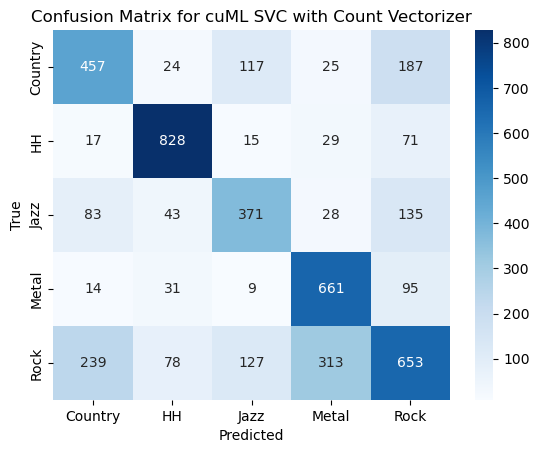

In [37]:
cuML_train(SVC_cuML, X_train_count_cupy, X_test_count_cupy, y_train_cupy, y_test_cupy, 'cuML SVC', 'Count Vectorizer')

[W] [14:12:26.733111] Sample weights are currently ignored for multi class classification
[W] [14:14:20.595877] Sample weights are currently ignored for multi class classification
[W] [14:16:15.122395] Sample weights are currently ignored for multi class classification
[W] [14:18:06.489816] Sample weights are currently ignored for multi class classification
[W] [15:32:02.664048] Sample weights are currently ignored for multi class classification

Classification Report for cuML SVC with Tfidf Vectorizer:
              precision    recall  f1-score   support

     Country       0.62      0.57      0.60       810
          HH       0.89      0.80      0.85       960
        Jazz       0.77      0.52      0.62       660
       Metal       0.70      0.78      0.74       810
        Rock       0.55      0.66      0.60      1410

    accuracy                           0.67      4650
   macro avg       0.71      0.67      0.68      4650
weighted avg       0.69      0.67      0.68      4650



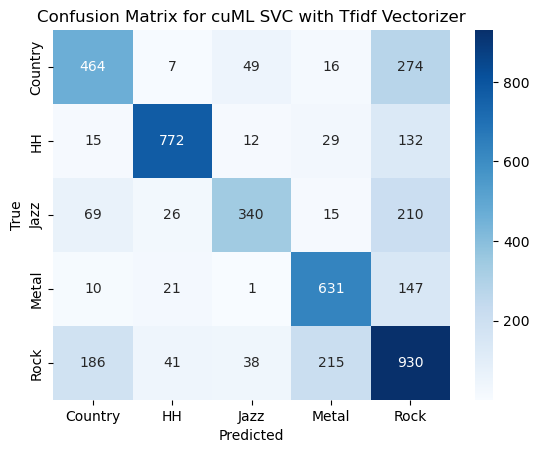

In [19]:
cuML_train(SVC_cuML, X_train_tfidf_cupy, X_test_tfidf_cupy, y_train_cupy, y_test_cupy, 'cuML SVC', 'Tfidf Vectorizer')

---

### Insights 


### 1. Logistic Regression with Count Vectorizer and Tf-idf Vectorizer:

#### Count Vectorizer:
- **Precision, recall, and F1-scores** are low for several classes, especially for "Country" and "Rock" genres, indicating difficulty in predicting these classes.
- **Confusion Matrix** shows a significant amount of misclassification for these classes. For example, many "Country" predictions are classified as "Rock."

#### Tf-idf Vectorizer:
- **Slight improvement in performance** over Count Vectorizer, especially for "Rock" and "Jazz."
- **Confusion Matrix** shows fewer misclassifications for some classes (e.g., "Rock"), but the model still struggles with distinguishing "Country" and "Jazz."

---

### 2. Random Forest with Count Vectorizer and Tf-idf Vectorizer:

#### Count Vectorizer:
- **Overall performance is poor**, particularly for "Country" and "Jazz."
- **Confusion Matrix** indicates the model is skewed towards predicting "Rock," with many other classes misclassified as "Rock."

#### Tf-idf Vectorizer:
- **Similar issues as Count Vectorizer**, though there is a slight improvement in performance metrics.
- **Confusion Matrix** shows improvement in predicting "HH" and "Jazz," but "Country" is still largely misclassified as "Rock."

---

### 3. cuML SVC with Count Vectorizer and Tf-idf Vectorizer (GPU-accelerated):

#### Count Vectorizer:
- **Significant improvement in performance**, especially in recall and F1-scores for most classes compared to previous models.
- **Confusion Matrix** shows better prediction of "HH" and "Jazz" with fewer misclassifications.

#### Tf-idf Vectorizer:
- **Best performance among all models**, with higher precision and recall scores across all classes.
- **Confusion Matrix** reflects fewer misclassifications, particularly for "Rock" and "Jazz," making this model the most accurate.

---

### Key Insights:
- **Tf-idf Vectorizer** generally performs better than **Count Vectorizer** across all models.
- **cuML SVC** offers the best performance due to GPU acceleration, providing faster and more accurate predictions compared to Logistic Regression and Random Forest.
- There is still room for improvement in distinguishing between certain genres like "Country" and "Rock."